In [55]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Tuple
import math
import import_ipynb

In [99]:
# 假設您已經運行以下檔案，確保相關類和函數可用
%run ./class_obj.ipynb
%run ./system_initial.ipynb
%run ./SINR_model.ipynb 

In [100]:
# 生成 IoT 網絡圖
def generate_IoT_graph(num_nodes: int, area_size: float = 1000.0, max_data_rate: int = 20) -> nx.Graph:
    """
    Generates a random connected IoT network graph with the specified number of nodes.
    Each node represents an IoT device (Task object) and is assigned a random (x, y) coordinate.
    Edges are weighted based on distance between IoT devices.

    參數:
    num_nodes (int): IoT 設備數量
    area_size (float): 座標範圍（節點座標將在 [0, area_size] x [0, area_size] 內生成）
    max_data_rate (int): IoT 設備的最大數據率

    返回:
    nx.Graph: 包含座標資訊的 IoT 網絡圖
    """
    G = nx.Graph()
    iot_devices = []
    for i in range(num_nodes):
        x = random.randint(0, area_size)
        y = random.randint(0, area_size)
        data_rate = random.randint(1, max_data_rate)
        iot_devices.append(Task(id=i, data_rate=data_rate, x=x, y=y))
        G.add_node(i, pos=(x, y), type="IoT", data_rate=data_rate)

    edges = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            pos1 = (iot_devices[i].x, iot_devices[i].y)
            pos2 = (iot_devices[j].x, iot_devices[j].y)
            distance = round(math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2), 2)
            edges.append((i, j, distance))

    random.shuffle(edges)
    connections = {i: [i] for i in range(num_nodes)}
    final_edges = []

    for edge in edges:
        node1, node2, weight = edge
        if connections[node1] != connections[node2]:
            final_edges.append((node1, node2, weight))
            old_group = connections[node2]
            for node in old_group:
                connections[node1].append(node)
                connections[node] = connections[node1]

    for edge in final_edges:
        node1, node2, weight = edge
        G.add_edge(node1, node2, weight=weight)

    return G, iot_devices


In [101]:
def add_mec_servers(G: nx.Graph, iot_devices: List[Task], num_mecs: int, num_tasks: int, cellRadius: float = 500) -> List[MEC_server]:
    """
    從 IoT 網絡圖中選擇 num_mecs 個節點作為 MEC server，確保覆蓋範圍不重疊。
    將每個 MEC 覆蓋範圍內的 IoT 節點加入其 set。

    參數:
    G (nx.Graph): IoT 網絡圖
    iot_devices (List[Task]): IoT 設備列表
    num_mecs (int): MEC server 數量
    num_tasks (int): 任務數量（用於計算每個 MEC 的 num）
    cellRadius (float): MEC 覆蓋半徑

    返回:
    List[MEC_server]: MEC server 列表
    """
    available_nodes = list(G.nodes())
    random.shuffle(available_nodes)

    num_tasks_per_mec = int(num_tasks / num_mecs) if num_mecs > 0 else 0

    mec_id = 0
    for node in available_nodes:
        if len(MECs) >= num_mecs:
            break

        center_x, center_y = G.nodes[node]['pos']
        overlap = False
        for mec in MECs:
            distance = math.sqrt((center_x - mec.center_x) ** 2 + (center_y - mec.center_y) ** 2)
            if distance < 2 * cellRadius:
                overlap = True
                break

        if not overlap:
            mec = MEC_server(m=mec_id, cellRadius=cellRadius, center_x=center_x, center_y=center_y, num=num_tasks_per_mec)
            MECs.append(mec)
            G.nodes[node]['type'] = 'MEC'

            for other_node in G.nodes():
                if other_node == node:
                    continue
                other_pos = G.nodes[other_node]['pos']
                distance = math.sqrt((center_x - other_pos[0]) ** 2 + (center_y - other_pos[1]) ** 2)
                if distance <= cellRadius and G.nodes[other_node].get('type', 'IoT') != 'MEC':
                    mec.covered_iots.add(other_node)

            mec_id += 1

    if len(MECs) < num_mecs:
        print(f"警告：無法生成 {num_mecs} 個不重疊的 MEC，只生成了 {len(MECs)} 個")

    return MECs

In [102]:
def MCE_server_setting(num_tasks: int, MECs: List[MEC_server], edge_ratio: float, scale: float = 3, cellRadius: float = 500, maxDataRate: int = 20) -> tuple[List[MEC_server], List[Task]]:
    """
    Construct MEC server and the relationship to tasks using pre-selected MEC servers.
    edge_ratio = 0 : Random distribution
    edge_ratio > 0 : Cell-edge distribution
    scale: Plot scale

    參數:
    num_tasks (int): 任務數量
    MECs (List[MEC_server]): 預先選擇的 MEC server 列表
    edge_ratio (float): 邊緣分佈比例
    scale (float): 繪圖縮放比例
    cellRadius (float): MEC 覆蓋半徑
    maxDataRate (int): 最大數據率

    返回:
    MECs (List[MEC_server]): MEC 設備列表
    tasks (List[Task]): 任務（IoT 點）列表
    """
    tasks = []
    lamb = 0.0005
    pi = np.pi
    mean = lamb * pi * cellRadius ** 2
    poisson_mean = np.random.poisson(mean)
    u_1 = np.random.uniform(edge_ratio, 1.0, num_tasks)
    radii = np.zeros(num_tasks)
    for i in range(num_tasks):
        radii[i] = cellRadius * (np.sqrt(u_1[i]))
    u_2 = np.random.uniform(0.0, 1.0, num_tasks)
    angle = np.zeros(num_tasks)
    for i in range(num_tasks):
        angle[i] = 2 * pi * u_2[i]

    fig = plt.gcf()
    ax = fig.gca()
    plt.xlim(-cellRadius, scale * cellRadius)
    plt.ylim(-cellRadius, scale * cellRadius)

    x = np.zeros(num_tasks)
    y = np.zeros(num_tasks)

    p = 0
    num_mecs = len(MECs)
    for m in range(num_mecs):
        num_tasks_per_mec = int(num_tasks / num_mecs)
        for u in range(p, p + num_tasks_per_mec):
            if u >= num_tasks:
                break
            x[u] = MECs[m].center_x + radii[u] * np.cos(angle[u])
            y[u] = MECs[m].center_y + radii[u] * np.sin(angle[u])
            tasks.append(Task(u, random.randint(1, maxDataRate), x[u], y[u]))
        p += num_tasks_per_mec

    for m in range(num_mecs):
        bs = plt.Circle((MECs[m].center_x, MECs[m].center_y), radius=cellRadius, color='r', linewidth=2, fill=False)
        ax.add_artist(bs)

    plt.plot(x, y, 'bo')
    ax.set_aspect(1)
    plt.show()

    return MECs, tasks



In [103]:
# 繪製最終圖形
def visualize_graph(G: nx.Graph, MECs: List[MEC_server], area_size: float = 1000.0):
    """
    繪製 IoT 網絡圖，顯示 MEC server 和其覆蓋的 IoT 節點。

    參數:
    G (nx.Graph): 網絡圖
    MECs (List[MEC_server]): MEC server 列表
    area_size (float): 座標範圍
    """
    plt.figure(figsize=(12, 12))
    pos = nx.get_node_attributes(G, 'pos')

    # 繪製 MEC 覆蓋範圍
    for mec in MECs:
        circle = plt.Circle((mec.center_x, mec.center_y), mec.cellRadius, color='red', fill=False, linestyle='--')
        plt.gca().add_artist(circle)

    # 繪製節點
    iot_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == 'IoT']
    mec_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == 'MEC']
    nx.draw_networkx_nodes(G, pos, nodelist=iot_nodes, node_color='orange', node_size=300, label='IoT Device')
    nx.draw_networkx_nodes(G, pos, nodelist=mec_nodes, node_color='lightblue', node_size=700, label='MEC Server')

    # 繪製邊
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5)

    # 添加節點標籤
    labels = {i: f"{i}\n({data['data_rate']})" for i, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_family='sans-serif')

    # 添加邊權重標籤
    edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # 設置圖形屬性
    plt.title("IoT Network Graph with MEC Servers", fontsize=14)
    plt.xlabel("X Coordinate", fontsize=12)
    plt.ylabel("Y Coordinate", fontsize=12)
    plt.grid(True)
    plt.gca().set_aspect('equal')
    plt.xlim(-area_size*0.5, area_size*1.5)
    plt.ylim(-area_size*0.5, area_size*1.5)
    plt.legend()
    plt.show()


In [104]:
def main_pipeline(num_nodes: int, num_mecs: int, num_tasks: int, edge_ratio: float, area_size: float = 1000.0, cellRadius: float = 500, max_data_rate: int = 20) -> nx.Graph:
    """
    主流程：生成 IoT 網絡圖，選擇 MEC server，分配覆蓋範圍，繪製圖形。

    參數:
    num_nodes (int): IoT 設備數量
    num_mecs (int): MEC server 數量
    num_tasks (int): 任務數量
    edge_ratio (float): 邊緣分佈比例
    area_size (float): 座標範圍
    cellRadius (float): MEC 覆蓋半徑
    max_data_rate (int): IoT 設備的最大數據率

    返回:
    nx.Graph: 最終圖
    """
   
    G, iot_devices = generate_IoT_graph(num_nodes, area_size, max_data_rate)
    print("初始 IoT 節點資訊:")
    for node, data in G.nodes(data=True):
        print(f"IoT Node {node}: pos={data['pos']}, data_rate={data['data_rate']}")

    MECs = add_mec_servers(G, iot_devices, num_mecs, num_tasks, cellRadius)
    print("\nMEC server 資訊:")
    for mec in MECs:
        print(f"{mec}, 覆蓋的 IoT 節點: {mec.covered_iots}")

    MECs, tasks = MCE_server_setting(num_tasks, MECs, edge_ratio, scale=3, cellRadius=cellRadius, maxDataRate=max_data_rate)
    print("\n任務資訊:")
    for task in tasks[:10]:
        print(task)

    for task in tasks:
        G.add_node(f"Task_{task.id}", pos=(task.x, task.y), type="Task", data_rate=task.data_rate)

    visualize_graph(G, MECs, area_size)

    return G

In [98]:
# 主程式
if __name__ == "__main__":
    # 假設的配置（替代 config）
    num_tasks = config['num_tasks']
    num_data_types = config['num_data_types']
    num_IoTs = config['num_IoTs']
    num_MECs = config['num_MECs']
    set_size = config['set_size']

    edge_ratio = 0
    area_size = 2000
    cellRadius = 500
    max_data_rate = 20

    G = main_pipeline(num_IoTs + num_MECs, num_MECs, num_tasks, edge_ratio, area_size, cellRadius, max_data_rate)
    print("\n最終圖的節點:")
    for node, data in G.nodes(data=True):
        print(f"Node {node}: {data}")
    print("\n最終圖的邊和權重:")
    for edge in G.edges(data=True):
        print(edge)

初始 IoT 節點資訊:
IoT Node 0: pos=(1482, 1257), data_rate=17
IoT Node 1: pos=(860, 944), data_rate=11
IoT Node 2: pos=(874, 1178), data_rate=11
IoT Node 3: pos=(101, 1017), data_rate=20
IoT Node 4: pos=(1377, 129), data_rate=17
IoT Node 5: pos=(765, 948), data_rate=5
IoT Node 6: pos=(332, 1626), data_rate=18
IoT Node 7: pos=(1388, 495), data_rate=6
IoT Node 8: pos=(1806, 1983), data_rate=16
IoT Node 9: pos=(1820, 334), data_rate=2
IoT Node 10: pos=(1481, 1141), data_rate=18
IoT Node 11: pos=(1497, 601), data_rate=3
IoT Node 12: pos=(1412, 676), data_rate=1
IoT Node 13: pos=(1463, 1443), data_rate=2
IoT Node 14: pos=(901, 1172), data_rate=18
IoT Node 15: pos=(112, 1827), data_rate=8
IoT Node 16: pos=(1336, 1221), data_rate=9
IoT Node 17: pos=(1048, 565), data_rate=10
IoT Node 18: pos=(1958, 402), data_rate=5
IoT Node 19: pos=(1580, 1472), data_rate=19
IoT Node 20: pos=(1362, 688), data_rate=6
IoT Node 21: pos=(1140, 347), data_rate=9
IoT Node 22: pos=(1598, 1074), data_rate=7
IoT Node 23: po

NameError: name 'MECs' is not defined

初始 IoT 節點資訊:
IoT Node 0: pos=(169, 1290), data_rate=4, stored_data=set()
IoT Node 1: pos=(271, 1315), data_rate=7, stored_data=set()
IoT Node 2: pos=(825, 227), data_rate=3, stored_data=set()
IoT Node 3: pos=(1822, 1858), data_rate=20, stored_data=set()
IoT Node 4: pos=(1055, 276), data_rate=2, stored_data=set()
IoT Node 5: pos=(1550, 1191), data_rate=6, stored_data=set()
IoT Node 6: pos=(676, 1179), data_rate=10, stored_data=set()
IoT Node 7: pos=(813, 713), data_rate=3, stored_data=set()
IoT Node 8: pos=(787, 877), data_rate=17, stored_data=set()
IoT Node 9: pos=(677, 1106), data_rate=12, stored_data=set()
IoT Node 10: pos=(1798, 1605), data_rate=3, stored_data=set()
IoT Node 11: pos=(531, 1610), data_rate=14, stored_data=set()
IoT Node 12: pos=(225, 1152), data_rate=5, stored_data=set()

MEC server 資訊:
MEC_server(m=0, cellRadius=500, center=(825, 227), num=3), 覆蓋的 IoT 節點: {4, 7}
MEC_server(m=1, cellRadius=500, center=(169, 1290), num=3), 覆蓋的 IoT 節點: {1, 11, 12}
MEC_server(m=2, cellR

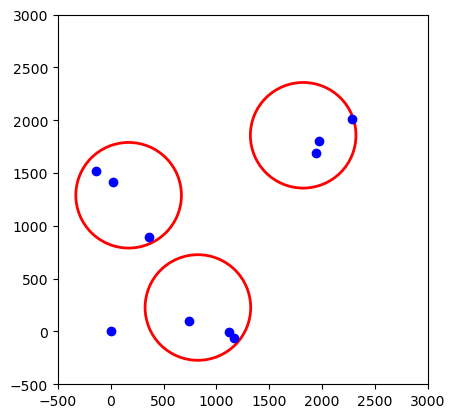


任務資訊:
Task_0 at (1171.3797940163972, -64.2834128905572) with data_rate=15
Task_1 at (1121.470097083184, -2.6419133830135593) with data_rate=10
Task_2 at (742.2798880271316, 96.12757841231252) with data_rate=19
Task_3 at (360.12060182324797, 892.9955022428636) with data_rate=13
Task_4 at (19.436970346092806, 1417.6037475298717) with data_rate=15
Task_5 at (-141.2842969468229, 1515.4855693200843) with data_rate=5
Task_6 at (1973.9392922617249, 1806.475216949903) with data_rate=16
Task_7 at (2280.1374420858824, 2012.942180717308) with data_rate=10
Task_8 at (1945.448549601187, 1688.746900291742) with data_rate=20


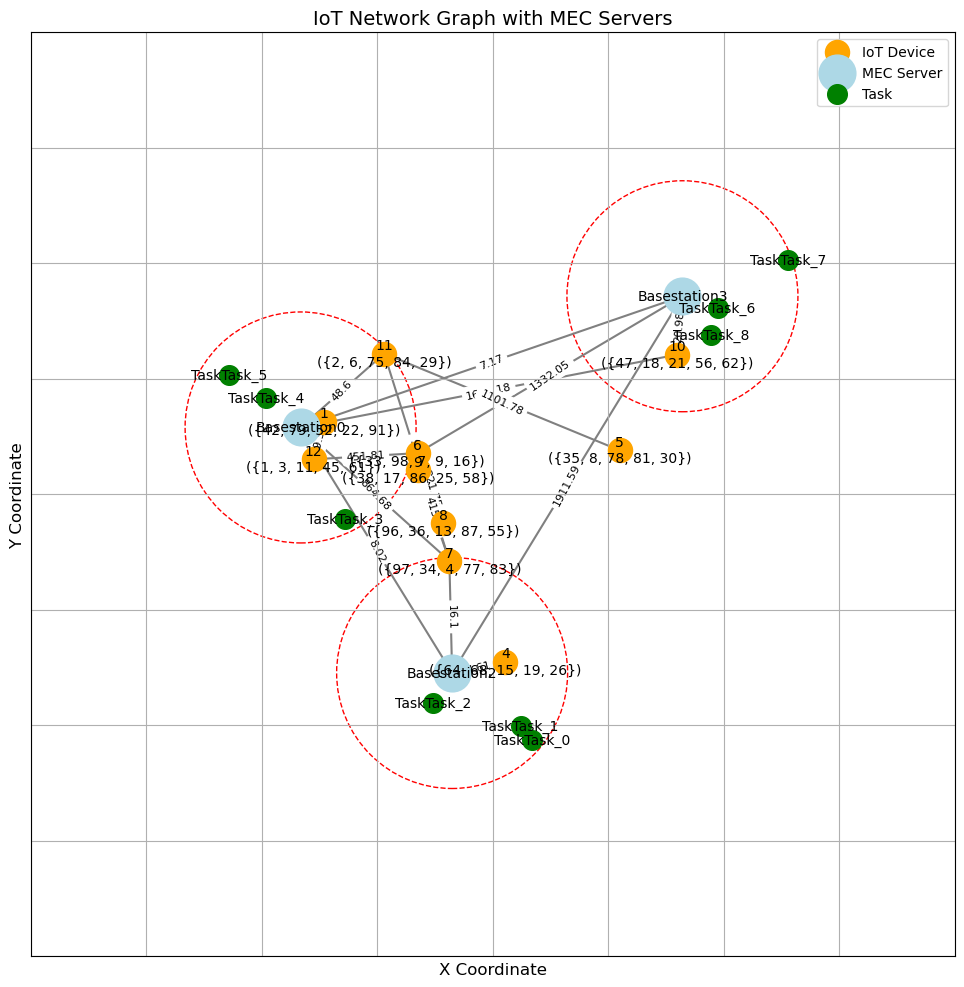


最終圖的節點:
Node 0: {'pos': (169, 1290), 'type': 'MEC', 'data_rate': 4}
Node 1: {'pos': (271, 1315), 'type': 'IoT', 'data_rate': 7, 'stored_data': {42, 79, 52, 22, 91}}
Node 2: {'pos': (825, 227), 'type': 'MEC', 'data_rate': 3}
Node 3: {'pos': (1822, 1858), 'type': 'MEC', 'data_rate': 20}
Node 4: {'pos': (1055, 276), 'type': 'IoT', 'data_rate': 2, 'stored_data': {64, 68, 15, 19, 26}}
Node 5: {'pos': (1550, 1191), 'type': 'IoT', 'data_rate': 6, 'stored_data': {35, 8, 78, 81, 30}}
Node 6: {'pos': (676, 1179), 'type': 'IoT', 'data_rate': 10, 'stored_data': {33, 98, 7, 9, 16}}
Node 7: {'pos': (813, 713), 'type': 'IoT', 'data_rate': 3, 'stored_data': {97, 34, 4, 77, 83}}
Node 8: {'pos': (787, 877), 'type': 'IoT', 'data_rate': 17, 'stored_data': {96, 36, 13, 87, 55}}
Node 9: {'pos': (677, 1106), 'type': 'IoT', 'data_rate': 12, 'stored_data': {38, 17, 86, 25, 58}}
Node 10: {'pos': (1798, 1605), 'type': 'IoT', 'data_rate': 3, 'stored_data': {47, 18, 21, 56, 62}}
Node 11: {'pos': (531, 1610), 'typ

In [ ]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Tuple
import math

# 生成 IoT 網絡圖
def generate_IoT_graph(num_nodes: int, area_size: float = 1000.0, max_data_rate: int = 20) -> Tuple[nx.Graph, List[IoT]]:
    G = nx.Graph()
    iot_devices = []
    for i in range(num_nodes):
        x = random.randint(0, area_size)
        y = random.randint(0, area_size)
        data_rate = random.randint(1, max_data_rate)
        iot_devices.append(IoT(id=i, data_rate=data_rate, x=x, y=y))
        G.add_node(i, pos=(x, y), type="IoT", data_rate=data_rate, stored_data=iot_devices[i].stored_data)

    edges = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            pos1 = (iot_devices[i].x, iot_devices[i].y)
            pos2 = (iot_devices[j].x, iot_devices[j].y)
            distance = round(math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2), 2)
            edges.append((i, j, distance))

    random.shuffle(edges)
    connections = {i: [i] for i in range(num_nodes)}
    final_edges = []

    for edge in edges:
        node1, node2, weight = edge
        if connections[node1] != connections[node2]:
            final_edges.append((node1, node2, weight))
            old_group = connections[node2]
            for node in old_group:
                connections[node1].append(node)
                connections[node] = connections[node1]

    for edge in final_edges:
        node1, node2, weight = edge
        G.add_edge(node1, node2, weight=weight)

    return G, iot_devices

# 添加 MEC server
def add_mec_servers(G: nx.Graph, iot_devices: List[IoT], num_mecs: int, num_tasks: int, cellRadius: float = 500) -> List[MEC_server]:
    MECs = []
    available_nodes = list(G.nodes())
    random.shuffle(available_nodes)

    num_tasks_per_mec = int(num_tasks / num_mecs) if num_mecs > 0 else 0

    mec_id = 0
    for node in available_nodes:
        if len(MECs) >= num_mecs:
            break

        center_x, center_y = G.nodes[node]['pos']
        overlap = False
        for mec in MECs:
            distance = math.sqrt((center_x - mec.center_x) ** 2 + (center_y - mec.center_y) ** 2)
            if distance < 2 * cellRadius:
                overlap = True
                break

        if not overlap:
            mec = MEC_server(m=mec_id, cellRadius=cellRadius, center_x=center_x, center_y=center_y, num=num_tasks_per_mec)
            MECs.append(mec)
            # CHANGED: 轉換為 MEC 時移除 stored_data
            G.nodes[node]['type'] = 'MEC'
            if 'stored_data' in G.nodes[node]:
                del G.nodes[node]['stored_data']  # 確保 MEC 節點不保留 stored_data

            for other_node in G.nodes():
                if other_node == node:
                    continue
                other_pos = G.nodes[other_node]['pos']
                distance = math.sqrt((center_x - other_pos[0]) ** 2 + (center_y - other_pos[1]) ** 2)
                if distance <= cellRadius and G.nodes[other_node].get('type', 'IoT') != 'MEC':
                    mec.covered_iots.add(other_node)

            mec_id += 1

    if len(MECs) < num_mecs:
        print(f"警告：無法生成 {num_mecs} 個不重疊的 MEC，只生成了 {len(MECs)} 個")

    return MECs

# 將 MEC 覆蓋的 IoT 連上邊
def add_covered_iot_edges(G: nx.Graph, mecs: List['MEC_server'], min_weight: float = 1.0, max_weight: float = 100.0):
    for mec in mecs:
        mec_node = None
        for node, data in G.nodes(data=True):
            if data['type'] == 'MEC' and data['pos'] == (mec.center_x, mec.center_y):
                mec_node = node
                break
        
        if mec_node is None:
            print(f"警告：找不到對應於 MEC {mec} 的節點")
            continue
        
        for iot_node in mec.covered_iots:
            if iot_node in G.nodes():
                weight = round(random.uniform(min_weight, max_weight), 2)
                G.add_edge(mec_node, iot_node, weight=weight)
            else:
                print(f"警告：IoT 節點 {iot_node} 不存在於圖中")

# 將 MEC 互相連起來
def connect_mec_servers(G: nx.Graph, mecs: List['MEC_server'], min_weight: float = 1.0, max_weight: float = 10.0):
    mec_nodes = []
    for mec in mecs:
        for node, data in G.nodes(data=True):
            if data['type'] == 'MEC' and data['pos'] == (mec.center_x, mec.center_y):
                mec_nodes.append(node)
                break
    
    if len(mec_nodes) != len(mecs):
        print(f"警告：只找到 {len(mec_nodes)} 個 MEC 節點，應有 {len(mecs)} 個")
    
    for i in range(len(mec_nodes)):
        for j in range(i + 1, len(mec_nodes)):
            node1 = mec_nodes[i]
            node2 = mec_nodes[j]
            if not G.has_edge(node1, node2):
                weight = round(random.uniform(min_weight, max_weight), 2)
                G.add_edge(node1, node2, weight=weight)

# MEC server 和任務設置
def MCE_server_setting(num_tasks: int, MECs: List[MEC_server], edge_ratio: float, scale: float = 3, cellRadius: float = 500, maxDataRate: int = 20) -> Tuple[List[MEC_server], List[Task]]:
    tasks = []
    lamb = 0.0005
    pi = np.pi
    mean = lamb * pi * cellRadius ** 2
    poisson_mean = np.random.poisson(mean)
    u_1 = np.random.uniform(edge_ratio, 1.0, num_tasks)
    radii = np.zeros(num_tasks)
    for i in range(num_tasks):
        radii[i] = cellRadius * (np.sqrt(u_1[i]))
    u_2 = np.random.uniform(0.0, 1.0, num_tasks)
    angle = np.zeros(num_tasks)
    for i in range(num_tasks):
        angle[i] = 2 * pi * u_2[i]

    fig = plt.gcf()
    ax = fig.gca()
    plt.xlim(-cellRadius, scale * cellRadius * 2)
    plt.ylim(-cellRadius, scale * cellRadius * 2)

    x = np.zeros(num_tasks)
    y = np.zeros(num_tasks)

    p = 0
    num_mecs = len(MECs)
    for m in range(num_mecs):
        num_tasks_per_mec = int(num_tasks / num_mecs)
        for u in range(p, p + num_tasks_per_mec):
            if u >= num_tasks:
                break
            x[u] = MECs[m].center_x + radii[u] * np.cos(angle[u])
            y[u] = MECs[m].center_y + radii[u] * np.sin(angle[u])
            tasks.append(Task(u, random.randint(1, maxDataRate), x[u], y[u]))
        p += num_tasks_per_mec

    for m in range(num_mecs):
        bs = plt.Circle((MECs[m].center_x, MECs[m].center_y), radius=cellRadius, color='r', linewidth=2, fill=False)
        ax.add_artist(bs)

    plt.plot(x, y, 'bo')
    ax.set_aspect(1)
    plt.show()

    return MECs, tasks

# 繪製圖形
def visualize_graph(G: nx.Graph, mecs: List['MEC_server'], area_size: float = 1000.0):
    plt.figure(figsize=(12, 12))
    pos = nx.get_node_attributes(G, 'pos')

    for mec in mecs:
        circle = plt.Circle((mec.center_x, mec.center_y), mec.cellRadius, color='red', fill=False, linestyle='--')
        plt.gca().add_artist(circle)

    iot_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == 'IoT']
    mec_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == 'MEC']
    task_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == 'Task']
    
    nx.draw_networkx_nodes(G, pos, nodelist=iot_nodes, node_color='orange', node_size=300, label='IoT Device')
    nx.draw_networkx_nodes(G, pos, nodelist=mec_nodes, node_color='lightblue', node_size=700, label='MEC Server')
    nx.draw_networkx_nodes(G, pos, nodelist=task_nodes, node_color='green', node_size=200, label='Task')
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5)

    labels = {}
    for i, data in G.nodes(data=True):
        if data['type'] == 'IoT':
            labels[i] = f"{i}\n({data.get('stored_data', 'None')})"
        elif data['type'] == 'MEC':
            labels[i] = f"Basestation{i}"
        elif data['type'] == 'Task':
            labels[i] = f"Task{i}"

    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_family='sans-serif')
    edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("IoT Network Graph with MEC Servers", fontsize=14)
    plt.xlabel("X Coordinate", fontsize=12)
    plt.ylabel("Y Coordinate", fontsize=12)
    plt.grid(True)
    plt.gca().set_aspect('equal')
    plt.xlim(-area_size * 0.5, area_size * 1.5)
    plt.ylim(-area_size * 0.5, area_size * 1.5)
    plt.legend()
    plt.show()

# 修改後的 distribute_numbers，確保每個集合大小為 set_size
def distribute_numbers(numbers: int, num_sets: int, set_size: int):
    if num_sets * set_size > numbers:
        raise ValueError(f"總資料數 {numbers} 不足以分配 {num_sets} 個大小為 {set_size} 的集合")
    
    all_numbers = list(range(numbers))
    random.shuffle(all_numbers)  # 隨機打亂資料
    sets = []
    
    for i in range(num_sets):
        start_idx = i * set_size
        end_idx = start_idx + set_size
        if start_idx >= len(all_numbers):  # 如果資料不足，提前結束
            break
        sets.append(set(all_numbers[start_idx:end_idx]))
    
    return sets

# 主流程
def main_pipeline(num_nodes: int, num_mecs: int, num_tasks: int, num_data_type: int, set_size:int, edge_ratio: float, area_size: float = 1000.0, cellRadius: float = 500, max_data_rate: int = 20) -> nx.Graph:
    # 第一步創建 IoT 圖
    G, IoTs = generate_IoT_graph(num_nodes, area_size, max_data_rate)
    
    print("初始 IoT 節點資訊:")
    for node, data in G.nodes(data=True):
        print(f"IoT Node {node}: pos={data['pos']}, data_rate={data['data_rate']}, stored_data={data.get('stored_data', 'None')}")

    # 第二步將節點改為 MEC
    MECs = add_mec_servers(G, IoTs, num_mecs, num_tasks, cellRadius)
    
    print("\nMEC server 資訊:")
    for mec in MECs:
        print(f"{mec}, 覆蓋的 IoT 節點: {mec.covered_iots}")
    
    # 第三步為 MEC 和覆蓋的 IoT 節點之間添加邊
    add_covered_iot_edges(G, MECs, min_weight=1.0, max_weight=100.0)
    print("\n添加 MEC 與覆蓋 IoT 之間的邊後的圖邊:")
    for edge in G.edges(data=True):
        print(edge)
    
    # 第四步 MEC 互相連接
    connect_mec_servers(G, MECs, min_weight=1.0, max_weight=10.0)
    print("\n添加 MEC 之間的邊後的圖邊:")
    for edge in G.edges(data=True):
        print(edge)
    
    # 第五步設定 MEC 上的任務分布
    MECs, tasks = MCE_server_setting(num_tasks, MECs, edge_ratio, scale=3, cellRadius=cellRadius, maxDataRate=max_data_rate)
    print("\n任務資訊:")
    for task in tasks[:10]:
        print(task)
    
    for task in tasks:
        G.add_node(f"Task_{task.id}", pos=(task.x, task.y), type="Task", data_rate=task.data_rate)
    
    # 第六步設定 IoT 上的資料
    num_IoTs = num_nodes - num_mecs
    sets = distribute_numbers(num_data_type, num_IoTs, set_size)
    # CHANGED: 只為仍為 IoT 的節點分配資料
    iot_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'IoT']
    for i, node in enumerate(iot_nodes):
        if i < len(sets):  # 確保不超出 sets 長度
            IoTs[node].stored_data = sets[i]  # 更新 IoTs 物件
            G.nodes[node]['stored_data'] = sets[i]  # 同步到 G
    
    visualize_graph(G, MECs, area_size)

    return G

# 主程式
if __name__ == "__main__":
    num_tasks = 10
    num_data_types = 100
    num_IoTs = 10
    num_MECs = 3
    set_size = 5

    edge_ratio = 0
    area_size = 2000
    cellRadius = 500
    max_data_rate = 20

    G = main_pipeline(num_IoTs + num_MECs, num_MECs, num_tasks, num_data_types, set_size, edge_ratio, area_size, cellRadius, max_data_rate)
    print("\n最終圖的節點:")
    for node, data in G.nodes(data=True):
        print(f"Node {node}: {data}")
    print("\n最終圖的邊和權重:")
    for edge in G.edges(data=True):
        print(edge)